In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
from copy import copy
#from scipy import ndimage
from scipy.interpolate import griddata, NearestNDInterpolator
from numpy import uint32, uint64, float64, float32, linspace, array, logspace, sin, cos, pi, arange
from arepy.read_write import binary_read as rsnap
from arepy.visualize import data_inspection as vis
from arepy.utility import snap_utility as snut
from scipy.optimize import curve_fit
from matplotlib import gridspec
from arepy.utility import cgs_constants as cgs
from scipy.spatial import Voronoi, Delaunay, ConvexHull, voronoi_plot_2d
from matplotlib.patches import Rectangle
plt.style.use('classic')

In [2]:
### constants: 
kb = 1.38e-23
kb_cgs = 1.38e-16
mH = 1.67e-24
mu = 2.8
h = 6.626e-34
h_cgs = 6.62e-27
gamma = 5./3.
pc2cm = 3.086e18
msun2g = 2e33

arepoLength = 3.0856e20
arepoMass = 1.991e33
arepoVel = 1.0e5

arepoTime = arepoLength/arepoVel
arepoDensity = arepoMass/arepoLength/arepoLength/arepoLength
arepoEnergy= arepoMass*arepoVel*arepoVel
arepoColumnDensity = arepoMass/arepoLength/arepoLength


In [ ]:
### Plot number of tracers inside 500pc
out_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/'
save_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/anal/'
rsnap.io_flags['sgchem'] = True
rsnap.io_flags['mc_tracer']=True

num_snaps = 100

t_array = np.zeros(num_snaps)
num_in1 = np.zeros(num_snaps)
num_in2 = np.zeros(num_snaps)
num_in3 = np.zeros(num_snaps)
num_in4 = np.zeros(num_snaps)
num_in5 = np.zeros(num_snaps)
num_step = 0

for isnap in arange(100,100+num_snaps):
  
  # read the data
  rsnap.io_flags['sgchem'] = True
  rsnap.io_flags['mc_tracer']=True
  data, header = rsnap.read_snapshot(out_path+'whole_disk_%03d'%isnap)
  t_array[isnap-100] = header['time']*97.8
  
  x,y,z=data['pos'].T
  x,y,z = x-120.0, y-120.0, z-10.0
  rho = data['rho']
  masses = data['mass']

  i_in1 = np.where(np.logical_and(data['numtrace']>0, (x**2 + y**2 < 0.5**2) ) )
  i_in2 = np.where(np.logical_and(data['numtrace']>0, (x**2 + y**2 < 1.0**2) ) )
  i_in3 = np.where(np.logical_and(data['numtrace']>0, (x**2 + y**2 < 1.5**2) ) )
  i_in4 = np.where(np.logical_and(data['numtrace']>0, (x**2 + y**2 < 2.0**2) ) )
  i_in5 = np.where(np.logical_and(data['numtrace']>0, (x**2 + y**2 < 4.0**2) ) )
  i_tot = np.where(data['numtrace']>0)
  print ""
  #num_in[num_step] = float(len(i_in[0]))/len(i_tot[0])
  num_in1[num_step] = float(len(i_in1[0]))
  num_in2[num_step] = float(len(i_in2[0]))
  num_in3[num_step] = float(len(i_in3[0]))
  num_in4[num_step] = float(len(i_in4[0]))      
  num_in5[num_step] = float(len(i_in5[0]))   
        
  num_step+=1
  
t_array = t_array

In [ ]:
t_array = (t_array) - 97.9

In [ ]:
#
plot_obj = plt.figure(3,figsize=(15,10))
ax = plot_obj.gca()
plt.plot(t_array,num_in1,label='Tracers within 100pc')
plt.plot(t_array,num_in2,label='Tracers within 150pc')
plt.plot(t_array,num_in3,label='Tracers within 200pc')
plt.plot(t_array,num_in4,label='Tracers within 400pc')
plt.plot(t_array,num_in5,label='Tracers within 1kpc')
plt.xlabel('Time of snapshot (MYr)')
plt.ylabel('Number of Tracers enclosed')
#ax.set_yscale('log')
ax.set_xlim(98,109)
#ax.set_ylim(1000,2000)

plt.legend(loc='best')
plt.savefig('inflow.png')
plt.show()

In [3]:
########################################################
### just look at a zoomed in region, look for cloud
########################################################

out_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/'
save_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/anal/'
rsnap.io_flags['sgchem'] = True
rsnap.io_flags['mc_tracer']=True
data, header = rsnap.read_snapshot(out_path+'whole_disk_200')


Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_200
Particles [ 53568882         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53568882
Tracer particles 117899847
Time =  [1.50006467]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>


In [4]:
t = header['time']
x,y,z=data['pos'].T
x,y,z = x-120.0, y-120.0, z-120.0
rho = data['rho']
masses = data['mass']
points = np.vstack((x,y,z)).T
rhof = NearestNDInterpolator(points,rho)

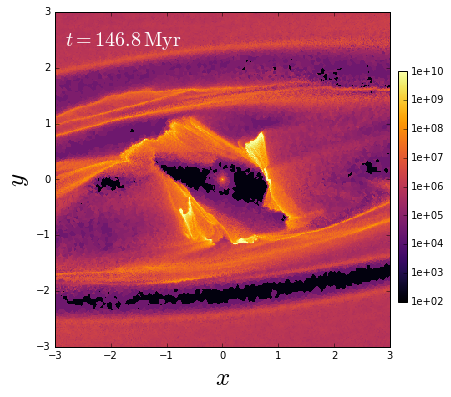

In [10]:
Nx, Ny, Nz = 401, 401, 11
plotrange=3
zslice=5
xgrid, ygrid, zgrid = linspace(-plotrange,plotrange,Nx), linspace(-plotrange,plotrange,Ny), linspace(-10,10,Nz)
XGRID,YGRID,ZGRID = np.meshgrid(xgrid,ygrid,zgrid)
RHO = rhof(XGRID,YGRID,ZGRID)
# plot
fig, ax = plt.subplots(1,1,figsize=(6,8))
u = 1.0
extent = (xgrid.min()/u,xgrid.max()/u,ygrid.min()/u,ygrid.max()/u)
levels = logspace(2,10,256)
norm = colors.BoundaryNorm(levels, 256)
#norm = colors.LogNorm(vmin=np.min(1e-25),vmax=np.max(1e-18))
im = ax.imshow(RHO[:,:,zslice],origin='l',norm=norm,extent=extent,cmap='inferno',interpolation='nearest')
ax.set_xlabel(r'$x$',fontsize=25)
ax.set_ylabel(r'$y$',fontsize=25)
ax.annotate(r'$t=%.1f\,\rm Myr$'%(t*97.856),xy=(0.03,0.9),xycoords='axes fraction',fontsize=20,color='w')
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(wspace=0.0,hspace=0.0)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
plt.colorbar(im,cax=cbar_ax,ticks=logspace(-10,10,21),format='%.0e',)#
plt.show()

#rr = np.array(plt.ginput(n=0,timeout=0)).T


In [16]:
rho.min(), rho.max()

(7.6098466e-10, 18385750000000.0)

In [3]:
########################################################
### Code to follow tracers back in time
########################################################

### First, define region of interest (ie cloud)
out_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/'
save_path = '/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/anal/'
rsnap.io_flags['sgchem'] = True
rsnap.io_flags['mc_tracer']=True
data, header = rsnap.read_snapshot(out_path+'whole_disk_200')
t = header['time']
x,y,z=data['pos'].T
x,y,z = x-120.0, y-120.0, z-120.0
rho = data['rho']
masses = data['mass']
vx,vy,vz = data['vel'].T
energy_per_unit_mass = data['u_therm']




Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_200
Particles [ 53568882         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53568882
Tracer particles 117899847
Time =  [1.50006467]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>


In [4]:
points = np.vstack((x,y,z)).T
rhof = NearestNDInterpolator(points,rho)

In [5]:

lowerx, upperx = -.61,-0.58
lowery, uppery = -0.44,-0.39
# lowerx, upperx = -.7,-0.5
# lowery, uppery = -0.4,-0.3
xw, yh = upperx-lowerx, uppery-lowery
print x.shape

cloud_reg = np.where( (x>lowerx) & (x<upperx) & (y>lowery) & (y<uppery) & (rho>4e10))
print cloud_reg[0].shape
cr = cloud_reg


(53568882,)
(545,)


In [6]:
cm_vx = np.average(vx[cr],weights=masses[cr])
cm_vy = np.average(vy[cr],weights=masses[cr])
cm_x = np.average(x[cr],weights=masses[cr])
cm_y = np.average(y[cr],weights=masses[cr])
rel_x = x[cr]-cm_x
rel_y = y[cr]-cm_y
#print np.mean(cm_vx), np.mean(vx[cr]), np.mean(cm_vy), np.mean(vy[cr]),
rel_vx = vx[cr]-cm_vx
rel_vy = vy[cr]-cm_vy


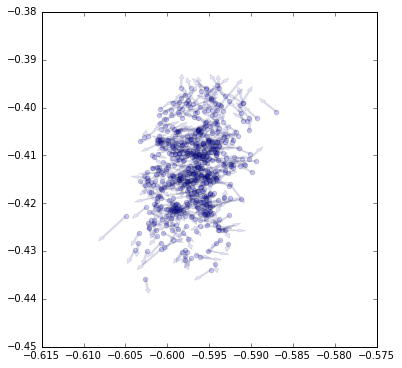

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(x[cr],y[cr],alpha=0.2)
for i in range(len(rel_vx)):
    ax.arrow(x=x[cr][i],y=y[cr][i],dx=rel_vx[i]/500,dy=rel_vy[i]/500,width=0.0002,alpha=0.1)


In [11]:
rot_proj = np.zeros_like(rel_vx)
theta = np.arctan(rel_y/rel_x)
xn, yn = np.sin(theta), np.cos(theta)
for i in range(len(rel_vx)):
    rot_proj[i]=np.dot((xn[i],yn[i]),(rel_vx[i],rel_vy[i]))/np.sqrt(rel_vx[i]**2+rel_vy[i]**2)
    

Text(0.5,0,'relative projection onto rotational axis')

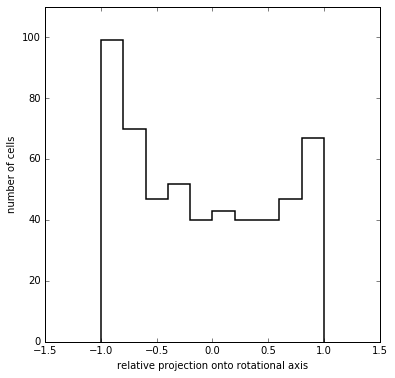

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(rot_proj,bins=10,histtype='step',lw=1.5,color='k')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(0,110)
ax.set_ylabel('number of cells')
ax.set_xlabel('relative projection onto rotational axis')

In [14]:
Nx, Ny, Nz = 401, 401, 11

plotrange=1.5
zslice=5
xgrid, ygrid, zgrid = linspace(-plotrange,plotrange,Nx), linspace(-plotrange,plotrange,Ny), linspace(-10,10,Nz)
XGRID,YGRID,ZGRID = np.meshgrid(xgrid,ygrid,zgrid)
RHO = rhof(XGRID,YGRID,ZGRID)

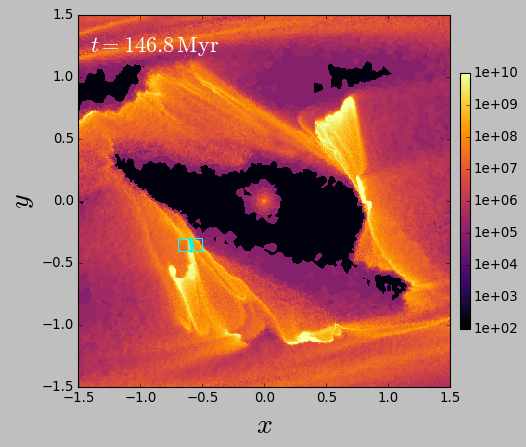

In [86]:
# plot
fig, ax = plt.subplots(1,1,figsize=(6,8))
u = 1.0
extent = (xgrid.min()/u,xgrid.max()/u,ygrid.min()/u,ygrid.max()/u)
levels = logspace(2,10,256)
#levels_T = levels = logspace(2,10,256)
norm = colors.BoundaryNorm(levels, 256)
#norm_T = colors.BoundaryNorm(levels_T, 256)
im = ax.imshow(RHO[:,:,zslice],origin='l',norm=norm,extent=extent,cmap='inferno',interpolation='nearest')
#im_T = ax.imshow(RHO_T[:,:,zslice],origin='l',norm=norm_T,extent=extent,cmap='inferno',interpolation='nearest')
ax.set_xlabel(r'$x$',fontsize=25)
ax.set_ylabel(r'$y$',fontsize=25)
ax.annotate(r'$t=%.1f\,\rm Myr$'%(t*97.856),xy=(0.03,0.9),xycoords='axes fraction',fontsize=20,color='w')
#ax.set_xlim(xgrid.min()/u,xgrid.max()/u)
#ax.set_ylim(ygrid.min()/u,ygrid.max()/u)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(wspace=0.0,hspace=0.0)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
plt.colorbar(im,cax=cbar_ax,ticks=logspace(-10,10,21),format='%.0e',)
#print x[cloud_reg], y[cloud_reg]
ax.scatter(x[cloud_reg],y[cloud_reg],s=0.1,color='cyan')
ax.add_patch(Rectangle((lowerx,lowery),width=xw,height=yh,edgecolor='cyan',fill=False))
plt.show()

In [51]:
### Now grab the ids of those tracers

cloud_tracers = np.where(np.isin(data['parentid'], data['id'][cloud_reg][:]))
mytracers = data['tracerid'][cloud_tracers]
print mytracers
print data['tracerid'].shape
print mytracers.shape
print len(mytracers)

[  866232 14387789 14374926 ... 22926919 42527282 74872244]
(117899847,)
(2248,)
2248


In [52]:
### Create arrays for previous tracer coordinates
numsnaps = 200
#xt = np.zeros((len(mytracers),numsnaps))
#yt = np.zeros((len(mytracers),numsnaps))
tempentry = np.zeros(1)
xlist = [tempentry]*numsnaps
ylist = [tempentry]*numsnaps
print len(mytracers)

2248


In [53]:
### faster code! but is it broken? no?
startsnap = 100
numsnaps=100
for isnap in arange(0,numsnaps):
  # read the data
  realsnap = startsnap + isnap 
  rsnap.io_flags['sgchem'] = True
  rsnap.io_flags['mc_tracer']=True
  data, header = rsnap.read_snapshot(out_path+'whole_disk_%03d'%realsnap)
  t = header['time']
  x,y,z=data['pos'].T
  x,y,z = x-120.0, y-120.0, z-120.0
  rho = data['rho']
  arr_tracerid = data['tracerid']
  arr_parentid = data['parentid']
  arr_id = data['id']
  #grab tracer positions at this snapshot
  istracer = np.isin(arr_tracerid,mytracers)
  itracerindex = np.where(istracer)
  iparentid = arr_parentid[itracerindex]
  isparent = np.isin(arr_id,iparentid)
  iparentindex = np.where(isparent)
  xlist[isnap] = x[iparentindex]
  ylist[isnap] = y[iparentindex]

Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_100
Particles [ 53662787         0 117899847         0         0         0]
Masses [0. 0. 0. 0. 0. 0.]
Gas particles 53662787
Tracer particles 117899847
Time =  [1.00048828]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_101
Particles [ 53649815         0 117899847         0         0         0]
Masses [0.         0.         5.35618115 0.         0.         0.        ]
Gas particles 53649815
Tracer particles 117899847
Time =  [1.00512582]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_102
Particles [ 53651336         0 117899847         0         0         0]
Masses [0.         0.         5.

ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_120
Particles [ 53976018         0 117899847         0         0         0]
Masses [0.         0.         5.33957738 0.         0.         0.        ]
Gas particles 53976018
Tracer particles 117899847
Time =  [1.10008767]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_121
Particles [ 53983544         0 117899847         0         0         0]
Masses [0.         0.         5.33957738 0.         0.         0.        ]
Gas particles 53983544
Tracer particles 117899847
Time =  [1.10504766]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_prod

Particles [ 54012480         0 117899847         0         0         0]
Masses [0.         0.         5.31761548 0.         0.         0.        ]
Gas particles 54012480
Tracer particles 117899847
Time =  [1.19501327]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_140
Particles [ 53968680         0 117899847         0         0         0]
Masses [0.         0.         5.31761548 0.         0.         0.        ]
Gas particles 53968680
Tracer particles 117899847
Time =  [1.20009463]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_141
Particles [ 53975930         0 117899847         0         0         0]
Masses [0.         0.         5.31761548 0.         0.         0.        ]
Gas

ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_159
Particles [ 53849075         0 117899847         0         0         0]
Masses [0.         0.         5.31761548 0.         0.         0.        ]
Gas particles 53849075
Tracer particles 117899847
Time =  [1.29509393]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_160
Particles [ 53842440         0 117899847         0         0         0]
Masses [0.         0.         5.31761548 0.         0.         0.        ]
Gas particles 53842440
Tracer particles 117899847
Time =  [1.30017529]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_prod

Particles [ 53845568         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53845568
Tracer particles 117899847
Time =  [1.39004156]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_179
Particles [ 53853816         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53853816
Tracer particles 117899847
Time =  [1.39501548]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_180
Particles [ 53806847         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas

ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_198
Particles [ 53577768         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53577768
Tracer particles 117899847
Time =  [1.49011683]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_fast/OUTPUT/whole_disk_199
Particles [ 53627863         0 117899847         0         0         0]
Masses [0.         0.         5.33459704 0.         0.         0.        ]
Gas particles 53627863
Tracer particles 117899847
Time =  [1.49509075]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>


In [28]:
#############################################
### calculate net angular momentum of cloud
#############################################
cm_vx = np.average(vx[cr],weights=masses[cr])
cm_vy = np.average(vy[cr],weights=masses[cr])
cm_vz = np.average(vz[cr],weights=masses[cr])
cm_x = np.average(x[cr],weights=masses[cr])
cm_y = np.average(y[cr],weights=masses[cr])
cm_z = np.average(z[cr],weights=masses[cr])
rel_x = x[cr]-cm_x
rel_y = y[cr]-cm_y
rel_z = z[cr]-cm_z
#print np.mean(cm_vx), np.mean(vx[cr]), np.mean(cm_vy), np.mean(vy[cr]),
rel_vx = vx[cr]-cm_vx
rel_vy = vy[cr]-cm_vy
rel_vz = vz[cr]-cm_vz


In [29]:
rel_v = np.array((rel_vx, rel_vy, rel_vz))
rel_r = np.array((rel_x, rel_y, rel_z))

In [30]:
pp_L = 2.0e30* np.cross(rel_v.T,rel_r.T)

In [31]:
totL_x = np.sum(pp_L[:,0])
totL_y = np.sum(pp_L[:,1])
totL_z = np.sum(pp_L[:,2])


In [32]:
print (totL_x,totL_y,totL_z)

(5.009534e+29, -3.0622752e+29, -6.527488e+29)


<IPython.core.display.Javascript object>


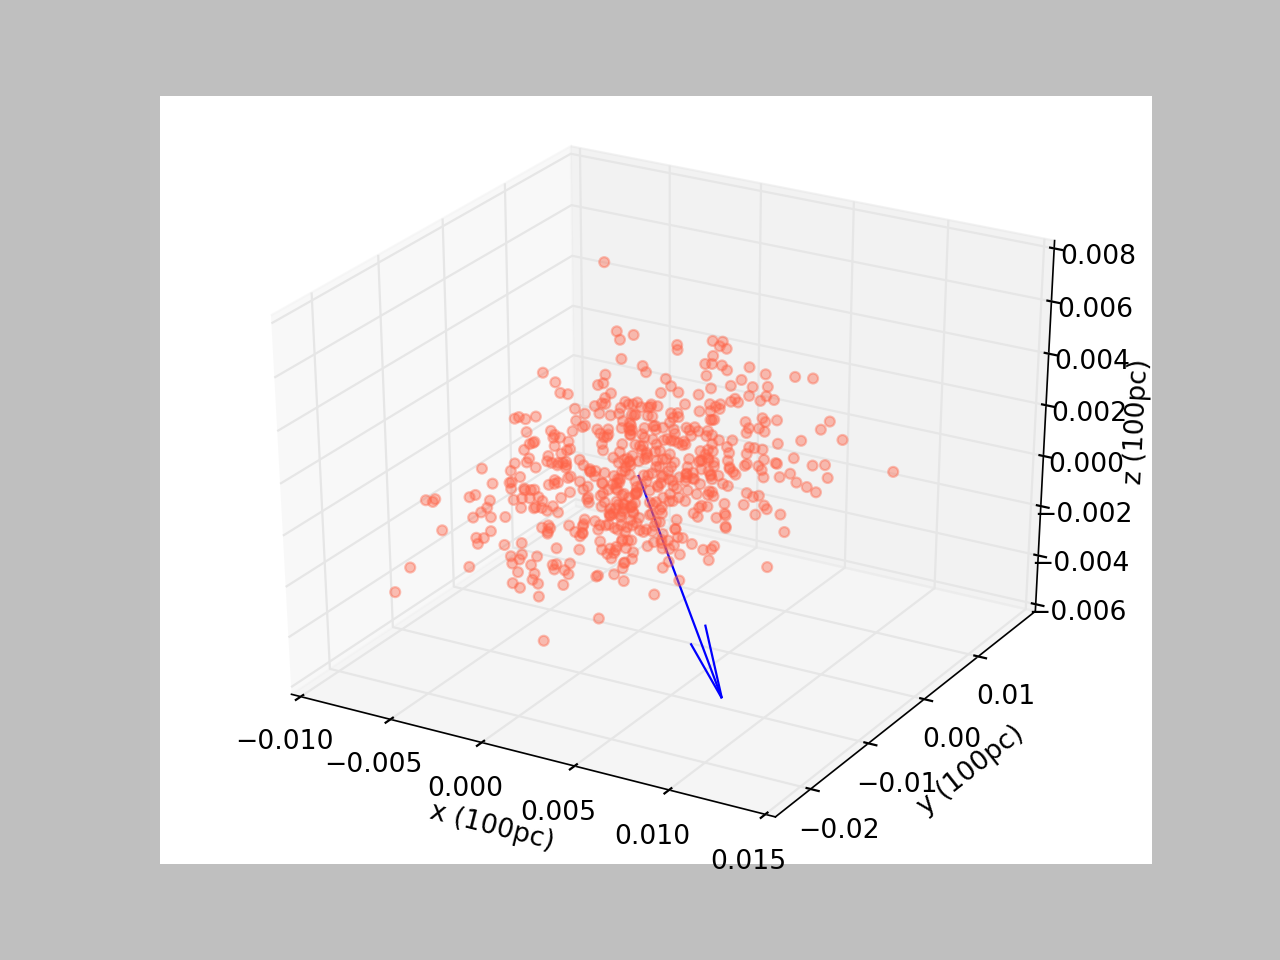

In [43]:
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x (100pc)')
ax.set_ylabel('y (100pc)')
ax.set_zlabel('z (100pc)')
ax.scatter(rel_x,rel_y,rel_z,alpha=0.4,color='tomato')
#ax.quiver(rel_x,rel_y,rel_z,rel_vx,rel_vy,rel_vz,alpha=0.3,color='blue',normalize=True)
ax.quiver(0, 0, 0, totL_x, totL_y, totL_z, length=0.01,normalize=True)
plt.show()

<IPython.core.display.Javascript object>


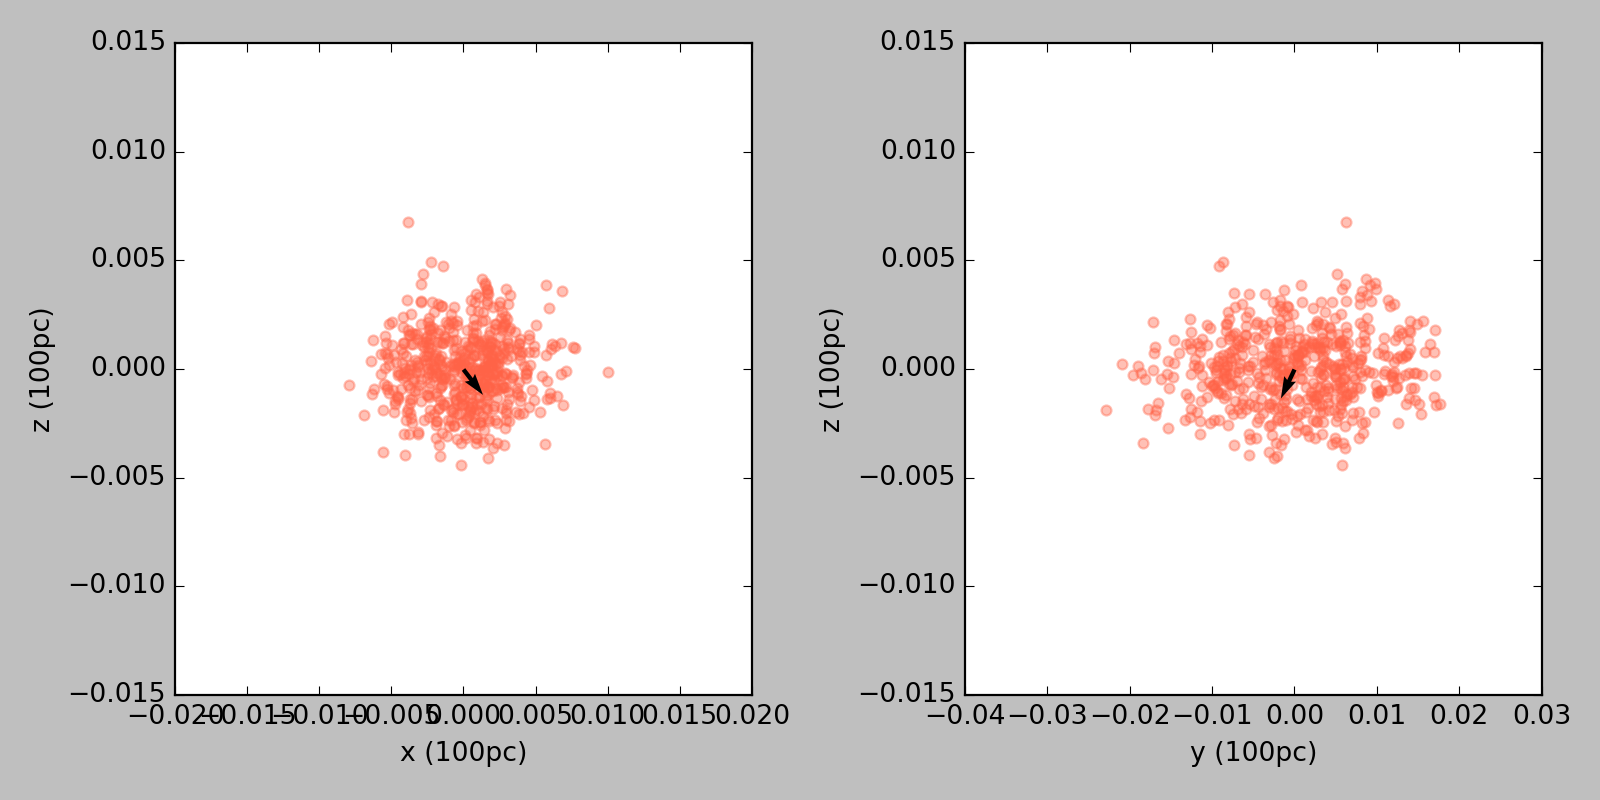

In [42]:
plt.close()
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax=axes[0]
ax.set_xlabel('x (100pc)')
ax.set_ylabel('z (100pc)')
ax.scatter(rel_x,rel_z,alpha=0.4,color='tomato')
ax.quiver(0, 0, totL_x, totL_z)
ax=axes[1]
ax.set_xlabel('y (100pc)')
ax.set_ylabel('z (100pc)')
ax.scatter(rel_y,rel_z,alpha=0.4,color='tomato')
ax.quiver(0, 0, totL_y, totL_z)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


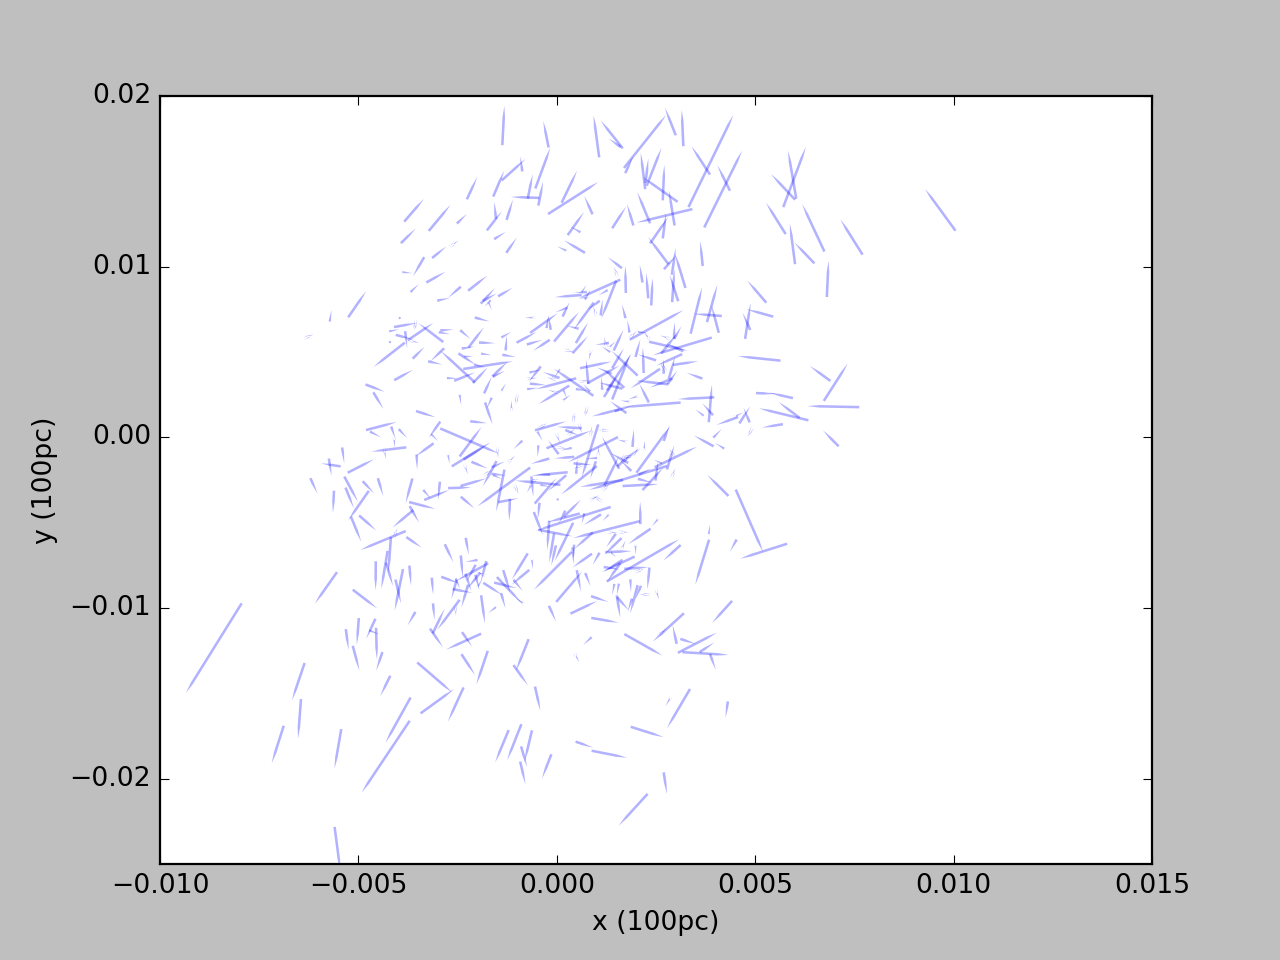

In [26]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x (100pc)')
ax.set_ylabel('y (100pc)')
ax.quiver(rel_x,rel_y,rel_vx,rel_vy,alpha=0.3,headwidth=0,headlength=0,color='blue')
#ax.quiver(0, 0, totL_x, totL_y)
#ax.set_ylim(-.45,-.38)
#ax.set_xlim(-0.605,-0.585)
plt.show()